In [132]:
import pandas as pd
import numpy as np
import time
import pdb
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation

In [133]:
def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    print(f'# This is a polynomial of order {o-1}.')
    y = 0
    coeffs = coeffs[::-1]
    for i in range(o):
        y += coeffs[i]*x**i
    return y

In [134]:
# constants
# note that ω is in units of Hz, not radians/sec
c = 299792458
ħ = 1.0545718e-34
Qi = 500000
Qc = 500000
Qtot = ( 1/Qi + 1/Qc )**-1
ω0 = c/1550e-9
λp = 1550e-9
ωp = c/λp
λp_start = 1549.99e-9# np.linspace(1548e-9,1551e-9,10000)
λp_end = 1550.03e-9
ωp_start = c/λp_start
ωp_end = c/λp_end
R = 60e-6 # radius
ng = 2.2
τ_tot = Qtot/ω0
FSR = c/(ng * 2*np.pi*R)
t = 1e-3 # seconds
t_roundtrip = 2*np.pi*ng*R/c
# we can normalize time to number of roundtrips
t_normal = t/t_roundtrip
# t_normal = t/(2*τ_tot)

β = -0.004 # Taylor expansion second order coefficient normalized by ω0/2 (half linewidth of the mode)
α = 1/τ_tot/2
γ = 1.4
F = 10 # pump normalized to threshold of parametric oscillation F^2 = pump/pump_threshold
# initialize ψ with noise
pump = 2 # watts
κext = ω0/Qc
F = np.sqrt(2*pump*κext)

Nmodes = 301
ωstart = ωp - (Nmodes//2) * FSR
ωend = ωp + (Nmodes//2) * FSR
# should i use cold cavity resonances or dispersion adjusted resonances?
ωarr = np.linspace(ωstart,ωend,Nmodes)
Dint_coeffs = np.array([ 7.38392840e-07, -1.08366836e-03,  6.20323154e-01, -1.52824970e+02,
                        2.00631574e+01,  9.25526200e+06, -2.25798494e+09,  2.33413386e+11,
                        -9.25346061e+12])
Dint_arr = PolyCoefficients(ωarr/1e12,Dint_coeffs)
# adjust mode wavelengths from calculated Dint
ωarr_adjusted = ωarr + Dint_arr

ψ = np.random.rand(Nmodes)/1#/np.sqrt(1e1) # starts off in the time domain
ψ = np.fft.ifft(ψ)

# simulation environment
Nsim = 300000
ωp_arr = np.linspace(ωp_start,ωp_end,Nsim)
tstep = t/Nsim

# This is a polynomial of order 8.


/home/suryajb/miniconda3/envs/research/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


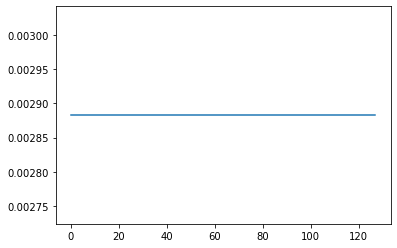

In [422]:
plt.plot(np.fft.ifft(seed))

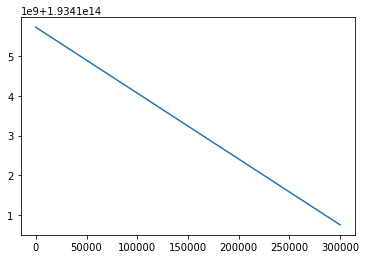

In [293]:
plt.plot(ωp_arr)

# This is a polynomial of order 8.


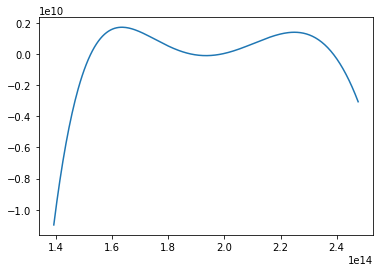

In [154]:
plt.plot(ωarr,PolyCoefficients(ωarr/1e12,Dint_coeffs))

In [201]:
α

386828978.06451607

In [235]:
F

39335.93665159207

In [91]:
# implement simple version, split step algorithm first.
# with tqdm(total=len(tickers)) as pbar:

# for np fft, need to do 1. fft, 2. fftshift, 3. perform calculations, 4. perform fftshift, 5. ifft

def split_step(Nsim,tstep,ωp_arr,ω0,ψ,α,γ,Dint_arr,F,R,t_roundtrip):
    h = tstep
    print(h)
    ψ_T = ψ
    L = 2 * np.pi * R
    with tqdm(total=Nsim) as pbar:
        for i in range(Nsim):
            N = (-(α-1j*(ωp_arr[i]-ω0)) + 1j*γ*np.dot(ψ_T,ψ_T))#**2#,ψ_T) # *********check if abs or dot
            ψ_T = np.exp(N*h)*ψ_T
            ψ_F = np.fft.fftshift(np.fft.fft(ψ_T))
            ψ_F = np.exp(-1j*Dint_arr*h)*ψ_F
            ψ_F[len(ψ_F)//2] += h*F
            ψ_T = np.fft.ifft(np.fft.fftshift(ψ_F))
            
            pbar.update(1)
            
            if not((i+1)%10000):
                plt.plot(np.abs(np.fft.fftshift(np.fft.fft(ψ_T)))**2)
                plt.show()
                print((np.fft.fftshift(np.fft.fft(ψ_T)))[150])
            
#     plt.plot(np.abs(np.fft.fft(ψ_T))**2)

def split_step_unitless():
    Nsim = 300000
    h = 1/Nsim
    β = -0.004
    Nmodes = 201
    θ = (np.linspace(-np.pi,np.pi,Nmodes))
    ω = np.linspace(-1*np.pi/2.7e-6,np.pi/2.7e-6,Nmodes) # np.linspace(-Nmodes//2+1,Nmodes//2,Nmodes)
    ψ = 0.5+np.exp(-(θ/0.1)**2)# np.random.rand(Nmodes)/10 # time domain  
    α = np.linspace(2,2,Nsim)
    ψ_T = ψ
    F = 60
    with tqdm(total=Nsim) as pbar:
        for i in range(Nsim):
            N = 1j*np.dot(ψ_T,ψ_T)#**2#,ψ_T) # *********check if abs or dot
            ψ_T = np.exp(N*h)*ψ_T
            ψ_F = np.fft.fftshift(np.fft.fft(ψ_T))
            # after fftshift, mode l-l0 is 0 in the middle, -100 on the left and +100 on the right
            ψ_F = np.exp((-(1+1j*1)-1j*β*(ω**2))*h/2)*ψ_F
            ψ_F[len(ψ_F)//2] += h*F
            ψ_T = np.fft.ifft(np.fft.fftshift(ψ_F))
#             ψ_T += h*F
            
            pbar.update(1)
            
            if not((i+1)%10000):
#                 pdb.set_trace()
                plt.plot(np.abs(ψ_T)**2)
                plt.show()
                print((np.fft.fftshift(np.fft.fft(ψ_T)))[150])
            

In [135]:
c = 299792458
ħ = 1.0545718e-34
Num_of_modes = 2**7
D2 = 15e6 # Hz
μ = np.arange(-Num_of_modes//2,Num_of_modes//2)
Dint = 2*np.pi*(μ**2 * D2/2)
dNu_ini = -2e8
dNu_end = 3e8
nn = 2000
ramp_stop = 0.99
dOm = 2*np.pi*np.concatenate([np.linspace(dNu_ini,dNu_end,int(nn*ramp_stop)),dNu_end*np.ones(int(np.round((1-ramp_stop)*nn)))])
# PhysicalParameters = {'n0': 1.9,
#                      'n2': 2.4e-19,
#                      'FSR': 1000e9,
#                      'w0': 2*np.pi*192e12,
#                      'width': 1.5e-6,
#                      'height': 1.35e-6,
#                      'κ_0': 25e6*2*np.pi,
#                      'κ_ex': 0.998**μ*25e6*2*np.pi,
#                      'Dint': Dint}
n0 = 1.9
n2 = 2.4e-19
FSR = 1e12
w0 = 2*np.pi*192e12
width = 1.5e-6
height = 1.35e-6
κ_0 = 25e6*2*np.pi
κ_ex = 25e6*2*np.pi#0.998**μ*25e6*2*np.pi
# simulation_parameters = {'slow_time': 2*1e-6, # 2 μs
#                         'detuning_array': dOm,
#                         'noise_level': 1e-7,
#                         'output': 'map',
#                         'absolute_tolerance': 1e-8,
#                         'relative_tolerance': 1e-8,
#                         'max_internal_steps': 2000}
slow_time = 2*1e-6
detuning_array = dOm
noise_level = 1e-7
output = 'map'
absolute_tolerance = 1e-8
max_internal_steps = 2000

P0 = 0.003
Pump = np.zeros(len(μ),dtype= 'complex')
Pump[0] = np.sqrt(P0)
dt = 1e-3/2

Tr = 1/FSR
Dint = np.fft.fftshift(Dint)
Aeff = width * height
Leff = c/n0*Tr
Veff = Aeff * Leff
g0 = ħ*w0**2*c*n2/n0**2/Veff
gamma = n2*w0/c/Aeff
κ = κ_0 + κ_ex
N_points = len(Dint)


T = slow_time # 2μs
out_param = output
detuning = detuning_array
eps = noise_level

pump = Pump * np.sqrt(1/(ħ*w0))

# renormalization
T_rn = (κ/2)*T
f0 = pump*np.sqrt(8*g0*κ_ex/κ**3)
print('f0^2 =',f0[0]**2)
print('xi [',(dOm[0]*2/κ),',',(dOm[-1]*2/κ),']')
# print(detuning[0]*2/8)
# print(κ[N_points//2])
def noise(a):
    return a*(np.random.uniform(-1,N_points)+1j*np.random.uniform(-1,1,N_points))
    
noise_const = noise(eps)
nn = len(detuning)

t_st = T_rn/nn
print('t_st =',t_st,'T_rn =',T_rn,κ)


def seed_level (pump, detuning):
    f_norm = pump*np.sqrt(1./(ħ*w0))*np.sqrt(8*g0*κ_ex/κ**3)
    detuning_norm  = detuning*2/κ
    stat_roots = np.roots([1, -2*detuning_norm, (detuning_norm**2+1), -abs(f_norm[0])**2])
    ind_roots = [np.imag(ii)==0 for ii in stat_roots]
    res_seed = np.zeros_like(f_norm)
    res_seed[0] = abs(stat_roots[ind_roots])**.5/np.sqrt(2*g0/κ)
    return res_seed

sol = np.ndarray(shape=(nn,N_points),dtype='complex')
seed = seed_level(Pump,detuning[0])*np.sqrt(2*g0/κ)
sol[0,:] = (noise_const*300000)#(seed)

with tqdm(total=nn) as pbar:
    pbar.update(1)
    for it in range(1,nn):
        curr_dOm = detuning[it]
        t = 0
        buf = sol[it-1]
        buf -= noise_const # frequency domain
        while t<t_st:
            buf_dir = np.fft.ifft(buf)
            f = np.fft.ifft(f0)*len(buf)
            buf_dir = np.fft.fft(np.exp(dt*(1j*np.abs(buf_dir)**2 + f/buf_dir))*buf_dir)
            buf=np.exp(-dt*(1+1j*(Dint+curr_dOm)*2/κ))*buf_dir
            t+=dt
            
        sol[it] = buf
        pbar.update(1)
    


f0^2 = (9.149454693395139+0j)
xi [ -8.0 , 12.0 ]
t_st = 0.15707963267948963 T_rn = 314.15926535897927 314159265.3589793


  0%|          | 0/2000 [00:00<?, ?it/s]

In [136]:
dOm

array([-1.25663706e+09, -1.25504960e+09, -1.25346213e+09, ...,
        1.88495559e+09,  1.88495559e+09,  1.88495559e+09])

In [408]:
power_dist = [sum(np.abs(np.fft.ifft(s))**2) for s in sol]

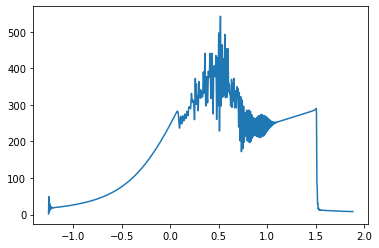

In [409]:
plt.plot(dOm/1e9,np.mean(np.abs(sol)**2,axis=1))

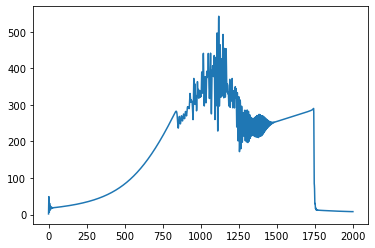

In [410]:
plt.plot(power_dist)

In [221]:
import pandas as pd
import glob
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import pdb
import time
import calendar
import pyfftw
from tqdm.notebook import tqdm


# note that ω is in units of Hz, not radians/sec

class microring:
    
    def __init__(self,R=60e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,12],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=10e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=[],Dint_file=None,dt=1e-3/2,
                Nmodes=2**8,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9,save=True,filename='combsol'):
        # constants
        self.c = 299792458
        self.ħ = 1.0545718e-34
        self.h = 6.62607015e-34
        
        # ring parameters
        self.R = R
        self.height = height
        self.width = width
        self.ng = ng
        if Qc_import:
            self.Qc = Qc_import
            self.Ql = (1/self.Qc[len(Qc_import)//2]+1/Qi)**-1
        else:
            self.Qc = Qc
            self.Ql = (1/Qc+1/Qi)**-1
        self.Qi = Qi
        self.L = 2*np.pi*R
        self.A = width*height
        self.FSR = self.c/(ng*self.L)
        self.t_roundtrip = 1/self.FSR
        self.mode_offset = mode_offset
        
        # laser parameters (ω is in Hz units)
        if λ0:
            self.λ0 = λ0
            self.ω0 = self.c/λ0
        else:
            self.ω0 = ω0
            self.λ0 = self.c/self.ω0
        
        # linewidth of resonance useful for normalization
        self.Δωtot = self.ω0/self.Ql #25e6*2#
        self.Δωext = self.ω0/self.Qc # 25e6
        self.Δωi = self.ω0/self.Qi
        
        if ω_range or λ_range:
            try:
                self.λ_start = λ_range[0]
                self.λ_end = λ_range[1]
                self.ω_start = self.c/λ_start
                self.ω_end = self.c/λ_end
            except:
                self.ω_start = ω_range[0]
                self.ω_end = ω_range[1]
                self.λ_start = self.c/self.ω_start
                self.λ_end = self.c/self.ω_end
            self.δnorm_range = [(self.ω0-self.ω_start)/(self.Δωtot/2),(self.ω0-self.ω_end)/(self.Δωtot/2)]
        else:
            self.δnorm_range = δnorm_range # normalized detuning array (normalized in terms of half linewidths)
            self.ω_start = self.ω0 - self.δnorm_range[0]*(self.Δωtot/2)
            self.ω_end = self.ω0 - self.δnorm_range[1]*(self.Δωtot/2)
            self.λ_start = self.c/self.ω_start
            self.λ_end = self.c/self.ω_end
        
        print(f'ω_start = {self.ω_start/1e12} THz, ω_end = {self.ω_end/1e12} THz')
        print(f'λ_start = {self.λ_start*1e9} nm, λ_end = {self.λ_end*1e9} nm')
        print(f'normalized detunings = [ {self.δnorm_range[0]} , {self.δnorm_range[1]} ] (relevant parameters: δnorm_range)')
        
        if total_time and (ω_sweep_speed is None) and (λ_sweep_speed is None):
            self.total_time = total_time
            self.ω_sweep_speed = np.abs(self.ω_end-self.ω_start)/total_time
            self.λ_sweep_speed = np.abs(self.λ_end-self.λ_start)/total_time
            print(f'sweep speed (ω space) = {self.ω_sweep_speed/1e9} GHz/s \nsweep speed (λ space) = {self.λ_sweep_speed*1e9} nm/s')
        elif ω_sweep_speed:
            self.ω_sweep_speed = ω_sweep_speed
            self.total_time = np.abs(self.ω_end-self.ω_start)/self.ω_sweep_speed
            print(f'total time = {self.total_time}')
        elif λ_sweep_speed:
            self.λ_sweep_speed = λ_sweep_speed
            self.total_time = np.abs(self.λ_end-self.λ_start)/self.λ_sweep_speed
            print(f'total time = {self.total_time}')
        else:
            print('no sweep speed or total time given (relevant parameters: λ_sweep_speed, ω_sweep_speed, total_time)')
        
        self.Tnorm = self.total_time*self.Δωtot/2
        self.dt=dt/(pump/0.003) # normalized dt, dt is not in units of seconds
        print(f"real time = {self.total_time}, normalized time = {self.Tnorm} (relevant parameters: total_time), dt = {dt}")
        self.Nsim = self.Tnorm//self.dt
        
        print(f'Simulation points = {self.Nsim} (relevant parameters: dt)')
        
        self.δarr = np.linspace(self.ω0-self.ω_start,self.ω0-self.ω_end,int(self.Nsim))# replaced last term with int(self.Nsim)
        print(f'detuning at start = {self.δarr[0]/1e9} GHz, detuning at end = {self.δarr[-1]/1e9} GHz (relevant parametes: ω_range, λ_range)')
        
        # old modes code
#         self.Nmodes = Nmodes
#         self.mode_arr = np.arange(-Nmodes/2,Nmodes/2)
#         self.μ = np.fft.fftshift(self.mode_arr)
#         self.ωarr = np.arange(-Nmodes/2,Nmodes/2)*self.FSR+self.ω0
        # new modes code
        self.Nmodes = Nmodes
        self.idx = Nmodes//2-mode_offset
        self.mode_arr = np.arange(-Nmodes/2+mode_offset,Nmodes/2+mode_offset)
        self.μ = self.fftshift(self.mode_arr,self.idx)
        self.ωarr = self.mode_arr*self.FSR+self.ω0
        
        # find coefficients for Dint if a file is given, if not, use the default.  The file has to have two columns with name 'lambda' and 'Dint'
        if Dint_file:
            df = pd.read_csv(Dint_file)
            df['lambda']=3e2/df['lambda']
            self.Dint_coeffs = np.polyfit(df['lambda'],df['Dint'],deg=Dint_degrees)
        else:
            self.Dint_coeffs = np.array([ 7.38392840e-07, -1.08366836e-03,  6.20323154e-01, -1.52824970e+02,
                                         2.00631574e+01,  9.25526200e+06, -2.25798494e+09,  2.33413386e+11,
                                         -9.25346061e+12])
        
        self.Dint_arr = self.PolyCoefficients(self.ωarr/1e12,self.Dint_coeffs)
        self.Dint_arr = self.fftshift(self.Dint_arr,self.idx) # self.Dint_arr = np.fft.ifftshift(self.Dint_arr)
        self.Dint_arr -= self.Dint_arr[0]
        self.ωarr_adjusted = self.ωarr+self.Dint_arr
        self.n2 = n2 # m^2 / W 
        self.Veff = self.A*self.L
        self.g0 = self.h*self.ω0**2*self.c*self.n2/self.ng**2/self.Veff # nonlinear gain (approximation since ω0 should represent laser wavelength)
        self.γ = self.n2*self.ω0/self.c/self.A
        
        if type(self.Δωext) == float: # maybe need it later on for engineering different coupling for different wavelengths
            self.Δωext_arr = np.linspace(self.Δωext,self.Δωext,self.Nmodes)
        else:
            self.Δωext_arr = self.Δωext
            
        # set vaccuum noise fluctuations that will initiate the comb
        self.normalization = np.sqrt(self.g0*2/self.Δωtot)
        self.noise_norm = self.set_noise()
        self.pump = pump
        self.Nsnapshots = snapshots
        self.δ_snapshots = np.linspace(self.δnorm_range[0],self.δnorm_range[1],self.Nsnapshots)
        self.sol = np.ndarray(shape=(self.Nsnapshots, self.Nmodes), dtype='complex')
        self.F_arr = np.zeros(self.Nmodes,dtype='complex') 
        self.F_arr[0] = np.sqrt(8*self.g0*self.Δωext*self.pump/(self.h*self.ω0)/self.Δωtot**3) # normalized power coupled into waveguide
        print(f'g0 = {self.g0}, Veff = {self.Veff}, F^2 = {np.abs(self.F_arr[0])**2}')
        self.norm_factor = np.sqrt(2*self.g0/self.Δωtot)
        self.sol[0,:]=self.noise_norm#self.seed
        self.plot_Dint()
        
        self.save = save
        self.filename = filename
        if '.csv' in self.filename:
            raise Exception("do not include '.csv' or suffix in filename")
        
    def PolyCoefficients(self, x, coeffs):
        """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

        The coefficients must be in ascending order (``x**0`` to ``x**o``).
        """
        o = len(coeffs)
        print(f'Dint is a polynomial of order {o-1}.')
        y = 0
        coeffs = coeffs[::-1]
        for i in range(o):
            y += coeffs[i]*x**i
        return y

    def set_noise(self):
        energy = self.h*(self.ωarr_adjusted)
        phase_noise = 2*np.pi*np.random.rand(self.Nmodes)
        arr = np.random.rand(self.Nmodes)
        normalized_noise = self.normalization*arr*np.sqrt(energy/2)*np.exp(1j*phase_noise)*self.Nmodes
        return normalized_noise

    def split_step(self,plan_fft=False,threads=1,wisdom=None):
        """split step method, initial seed starts off in the frequency domain"""
        with tqdm(total=self.Nsnapshots) as pbar:
            divbysnapshot = self.Nsim//self.Nsnapshots
            sol_track = 0
            ψf = self.sol[0,:]
            F_arr = np.fft.ifft(self.F_arr)*(self.Nmodes)
            ψf += self.F_arr*self.Nmodes*self.dt
            # Plan ifft/fft
            ifft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # frequency domain
            fft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # time domain
            fft_object = pyfftw.FFTW(fft_arr,ifft_arr,threads=threads,flags=('FFTW_MEASURE',))
            ifft_object = pyfftw.FFTW(ifft_arr,fft_arr,direction='FFTW_BACKWARD',threads=threads,flags=('FFTW_MEASURE',))
            ifft_arr[:] = ψf
            # some additional ways of using pyfftw builders to initialize fft arrays in memory
            #             ifft_object = pyfftw.builders.ifft(ifft_arr)
            # sometimes overhead of setting up additional threads is not worth it
#             ifft_build = pyfftw.builders.ifft(ψf,threads=8)
            # Plan fft
#             fft_object = pyfftw.builders.fft(fft_arr)
            if wisdom:
                pyfftw.import_wisdom(wisdom)
            
            if plan_fft:
                for i in range(int(self.Nsim)):
                    detuning = self.δarr[i]
                    Dispersion = -(self.dt/2) *((self.Δωext+self.Δωi)/self.Δωtot+1j*(self.Dint_arr + detuning)*2/self.Δωtot )
                    ifft_arr[:] = np.exp(Dispersion) * ifft_arr
    #                 ψt = np.fft.ifft(ψf) # convert to time domain
                    ifft_object()
    #                 ψf = np.fft.fft(np.exp(self.dt *(1j *  np.abs(ψt) ** 2 + F_arr/ψt )) * ψt)
                    fft_arr[:] = np.exp(self.dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr )) * fft_arr
                    fft_object()
                    ifft_arr[:] = np.exp(Dispersion) * ifft_arr
                    ifft_arr += self.noise_norm
                    if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
                        self.sol[sol_track,:] = ifft_arr
                        sol_track += 1
                        pbar.update(1)
            else:
                for i in range(int(self.Nsim)):
                    ψf = np.exp(-(self.dt/2) *((self.Δωext+self.Δωi)/self.Δωtot+1j*(self.Dint_arr + self.δarr[i])*2/self.Δωtot )) * ψf
                    ψt = np.fft.ifft(ψf) # convert to time domain
#                     ψt = ifft_object(ψf)
                    ψf = np.fft.fft(np.exp(self.dt *(1j *  np.abs(ψt) ** 2 + F_arr/ψt )) * ψt)
#                     ψf = fft_object(np.exp(self.dt *(1j *  np.abs(ψt) ** 2 + F_arr/ψt )) * ψt)
                    ψf = np.exp(-(self.dt/2) *((self.Δωext+self.Δωi)/self.Δωtot+1j*(self.Dint_arr + self.δarr[i])*2/self.Δωtot )) * ψf
                    ψf += self.noise_norm
                    if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
                        self.sol[sol_track,:] = ψf
                        sol_track += 1
                        pbar.update(1)
            
            if plan_fft:
                self.wisdom = pyfftw.export_wisdom()
            
            if self.save:
                self.save_sol()
        pass
        
    def plot_intracavity_power(self):
        plt.plot(self.δ_snapshots,np.mean(np.abs(self.sol)**2*self.normalization**2,axis=1))
        plt.show()
        
    def plot_all(self,idx=None):
        norm_factor = self.h*self.ω0/self.normalization**2
        intracavity_power = np.sum(np.abs(self.sol[:])**2,axis=1)*norm_factor
        if idx is None:
            differences = (np.diff(np.sum(np.abs(self.sol[:])**2,axis=1)))
            idx = np.where(differences>0)[0][np.argmin(differences[np.where(differences>0)])]-100
        fig, axs = plt.subplots(4,1,figsize=(10,13))
        zeros_arr = np.linspace(0,0,self.Nmodes)
        axs[0].plot(self.ωarr/1e12,self.ifftshift(self.Dint_arr,self.idx)/1e9) # axs[0].plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        axs[0].plot(self.ωarr/1e12,zeros_arr,'r-')
        axs[0].set_xlabel('Frequency (THz)')
        axs[0].set_ylabel('Dint (GHz)')

        axs[1].plot(np.sum(np.abs(self.sol[:])**2,axis=1)*norm_factor)
        axs[1].plot(idx,np.sum(np.abs(self.sol[idx])**2)*norm_factor,'r*',markersize=12)
        axs[1].set_xlabel('snapshot #')
        axs[1].set_ylabel('Intracavity power (W)')
#         axs[2].stem(self.ωarr/1e12,10*np.log10(np.abs(np.fft.fftshift(self.sol[idx]))**2*1e3*norm_factor),
#                  bottom=np.min(10*np.log10(np.abs(np.fft.fftshift(self.sol[idx]))**2*1e3*norm_factor)),markerfmt='')
        axs[2].stem(self.ωarr/1e12,10*np.log10(np.abs(self.ifftshift(self.sol[idx],self.idx))**2*1e3*norm_factor),
                 bottom=np.min(10*np.log10(np.abs(self.ifftshift(self.sol[idx],self.idx))**2*1e3*norm_factor)),markerfmt='')
        axs[2].set_xlabel('Frequency (THz)')
        axs[2].set_ylabel('Intracavity power (dBm)')
        axs[3].plot(np.linspace(-np.pi,np.pi,self.Nmodes),np.log10(np.abs(np.fft.ifft(self.sol[idx]))**2))
        axs[3].set_xlabel('θ')
        axs[3].set_ylabel('Log10($|\psi|^2$)')
        fig.tight_layout()
        plt.show()
        
    def plot_Dint(self):
        zeros_arr = np.linspace(0,0,self.Nmodes)
        fig, ax = plt.subplots(1,1,figsize=(4,2))
        ax.plot(self.ωarr/1e12,self.ifftshift(self.Dint_arr,self.idx)/1e9)# ax.plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        ax.plot(self.ωarr/1e12,zeros_arr,'r-')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Dint (GHz)')
        fig.tight_layout()
        plt.show()
        
    def fftshift(self,lst,idx):
        return np.concatenate((lst[idx:],lst[0:idx]))
    
    def ifftshift(self,lst,idx):
        return np.concatenate((lst[-idx:],lst[0:-idx]))
    
    def save_sol(self):
        idx = 1
        file_list = [os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]
        new_filename = self.filename
        while new_filename+'.csv' in file_list:
            new_filename = self.filename + '_' + f'{idx:03}'
            idx += 1
        pd.DataFrame(self.sol.T).to_csv(new_filename + '.csv')

In [205]:

# print(os.path.basename(os.getcwd()))
sorted(glob.glob(os.getcwd()+'/*'))
[os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]

['comb_utils.py',
 'epfl.ipynb',
 '2.500w_58.5r_0.960h.csv',
 'comb_simulation_t1.ipynb',
 'Untitled.ipynb',
 '2.300w_58.5r_0.945h.csv',
 'simple_combsim.ipynb',
 '_15th_combsol_freqspace.csv']

In [191]:
pd.DataFrame(_15th.sol.T).to_csv('_15th_combsol_freqspace.csv')

In [223]:
_15th.save_sol()

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.0005
Simulation points = 32235748.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 5.
g0 = 0.42497332143241495, Veff = 8.670795723907829e-16, F^2 = 22.160452909848882


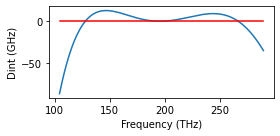

In [222]:
_15th = microring(Nmodes=2**9,total_time=1e-6,δnorm_range=[-8,20],pump=250e-3,dt=1e-3/2,Dint_file='2.500w_58.5r_0.960h.csv',Dint_degrees=5,snapshots=2000,
                 mode_offset=10,R=60e-6,filename='first_sol') # 2.500w_58.5r_0.960h

In [177]:
_15th.split_step(plan_fft=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

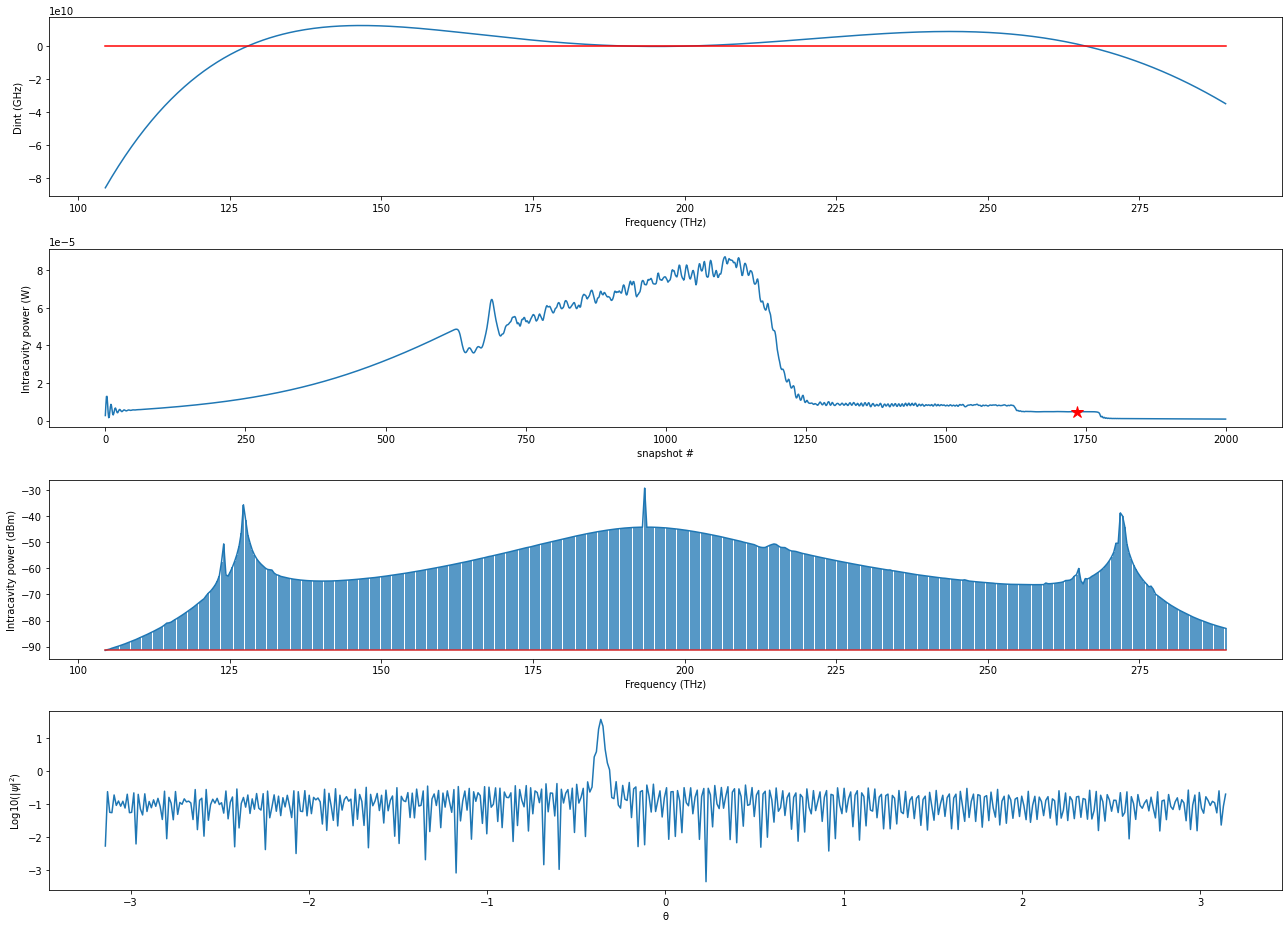

In [179]:
_15th.plot_all()

ω_start = 193.4160363481703 THz, ω_end = 193.4086865975871 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.046501395042 nm
normalized detunings = [ -8 , 30 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 7349750.58321875 GHz/s 
sweep speed (λ space) = 58901.29584266704 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 5.80243467096875 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 5.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


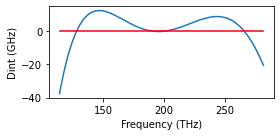

In [130]:
_14th = microring(Nmodes=2**10,total_time=1e-6,δnorm_range=[-8,30],pump=300e-3,dt=1e-3,Dint_file='2.500w_58.5r_0.960h.csv',Dint_degrees=5,snapshots=2000,
                 mode_offset=28) # 2.500w_58.5r_0.960h

In [131]:
_14th.split_step(plan_fft=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

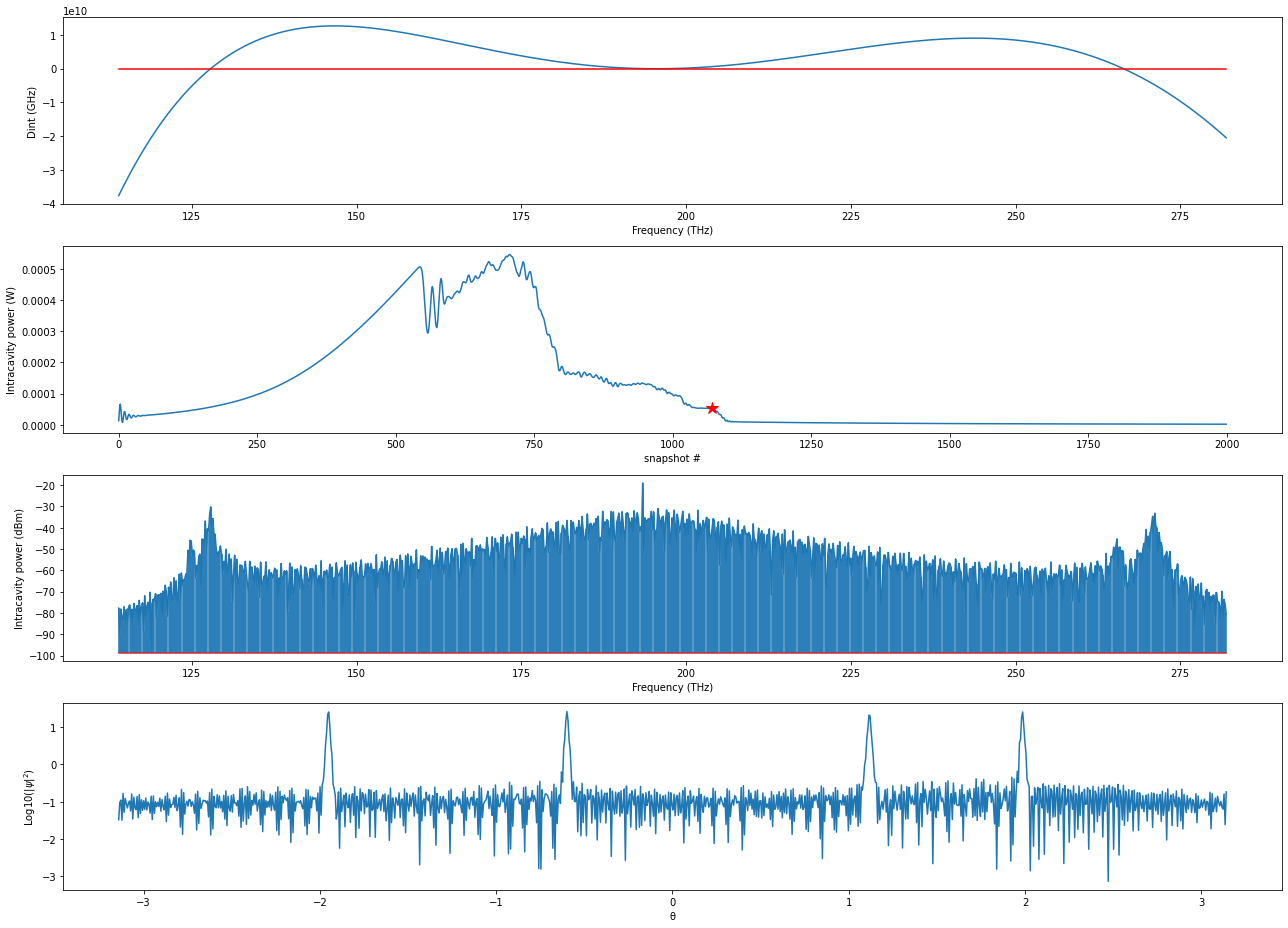

In [134]:
_14th.plot_all(1070)

ω_start = 193.4160363481703 THz, ω_end = 193.4086865975871 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.046501395042 nm
normalized detunings = [ -8 , 30 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 7349750.58321875 GHz/s 
sweep speed (λ space) = 58901.29584266704 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 5.80243467096875 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


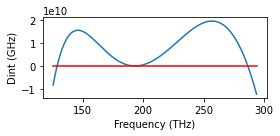

In [101]:
_13th = microring(Nmodes=2**10,total_time=1e-6,δnorm_range=[-8,30],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9,snapshots=2000,
                 mode_offset=100)

In [102]:
_13th.split_step(plan_fft=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

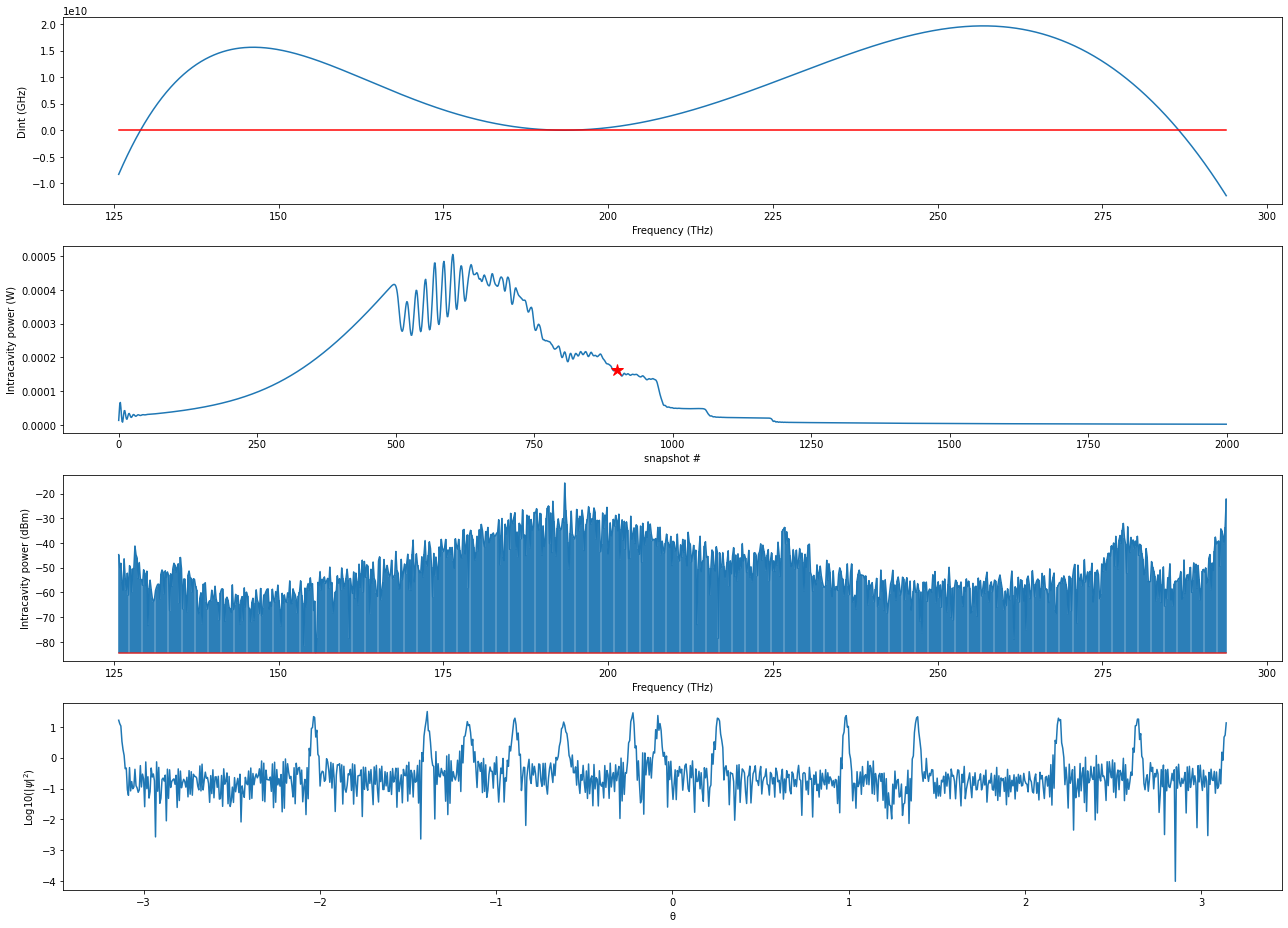

In [108]:
_13th.plot_all(900)

In [89]:
offset=5
arr = np.arange(-10+offset,10+offset)
print(_13th.fftshift(arr,offset))
_13th.ifftshift(_13th.fftshift(arr,offset),offset)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 -5 -4 -3 -2 -1]


array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14])

ω_start = 193.4160363481703 THz, ω_end = 193.4086865975871 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.046501395042 nm
normalized detunings = [ -8 , 30 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 7349750.58321875 GHz/s 
sweep speed (λ space) = 58901.29584266704 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 5.80243467096875 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


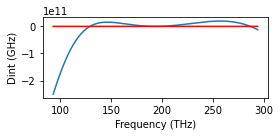

  0%|          | 0/2000 [00:00<?, ?it/s]

In [44]:
eleventh = microring(Nmodes=2**10+200,total_time=1e-6,δnorm_range=[-8,30],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9,snapshots=2000)
eleventh.split_step(plan_fft=True)

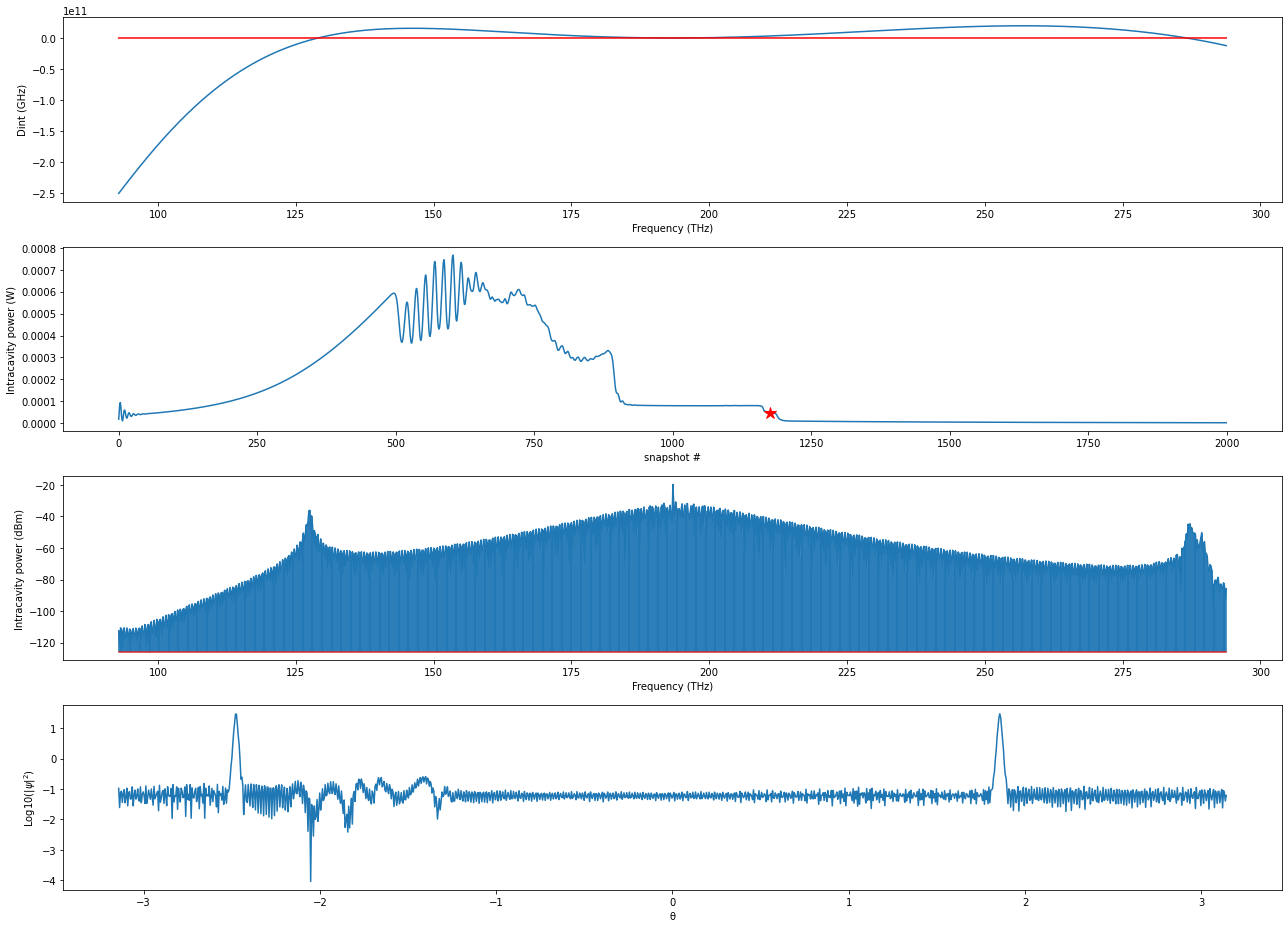

In [107]:
eleventh.plot_all(1175)

ω_start = 193.4160363481703 THz, ω_end = 193.4086865975871 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.046501395042 nm
normalized detunings = [ -8 , 30 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 7349750.58321875 GHz/s 
sweep speed (λ space) = 58901.29584266704 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 5.80243467096875 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


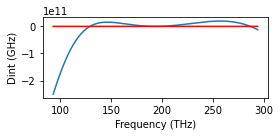

In [27]:
tenth = microring(Nmodes=2**10+200,total_time=1e-6,δnorm_range=[-8,30],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9,snapshots=2000)

In [28]:
tenth.split_step(plan_fft=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

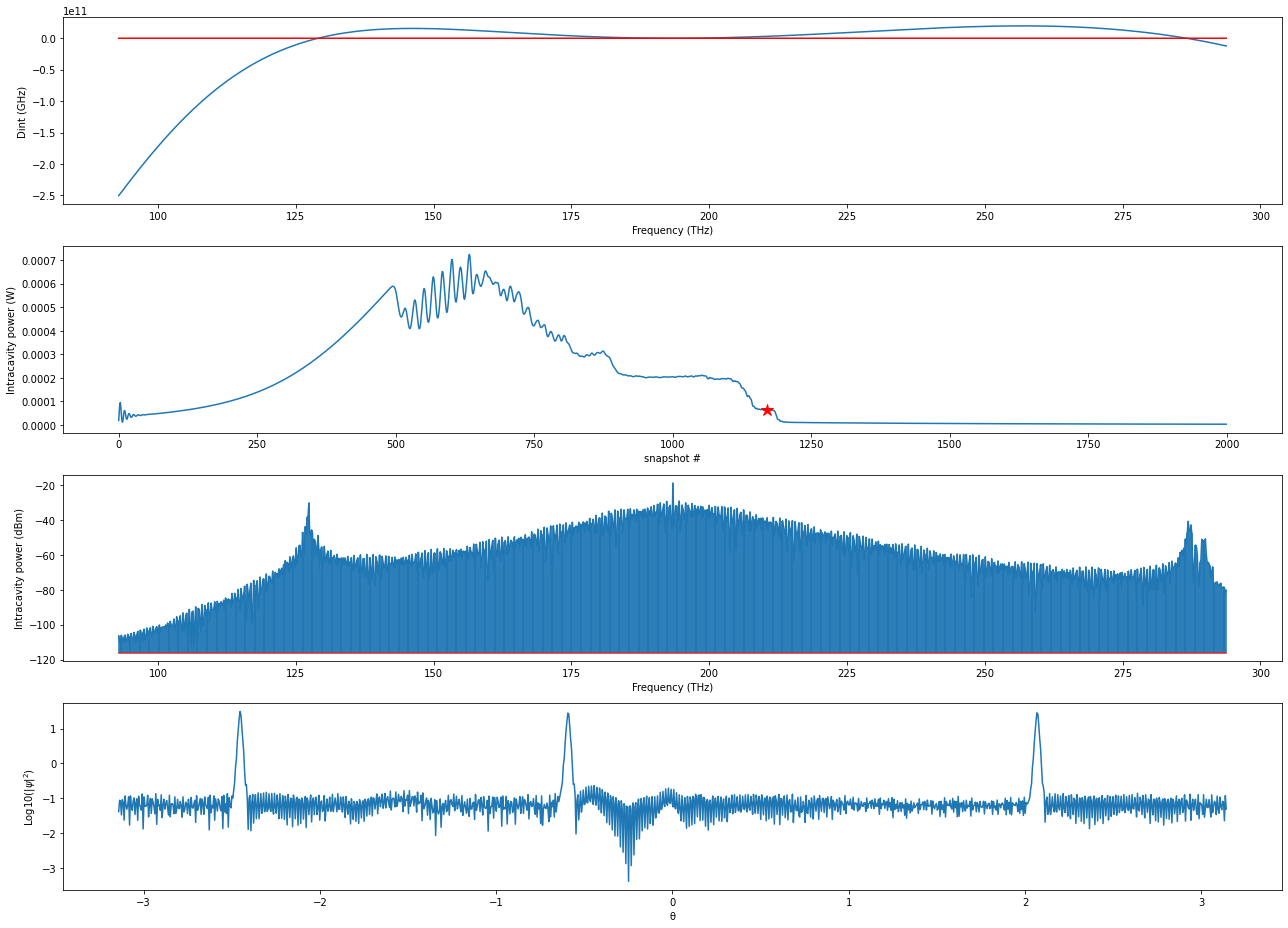

In [33]:
tenth.plot_all(1170)

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


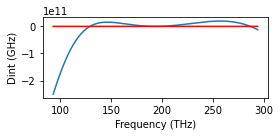

In [140]:
ninth = microring(Nmodes=2**10+200,total_time=1e-6,δnorm_range=[-8,20],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9,snapshots=2000)
ninth.plot_Dint()

In [144]:
ninth.split_step(plan_fft=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

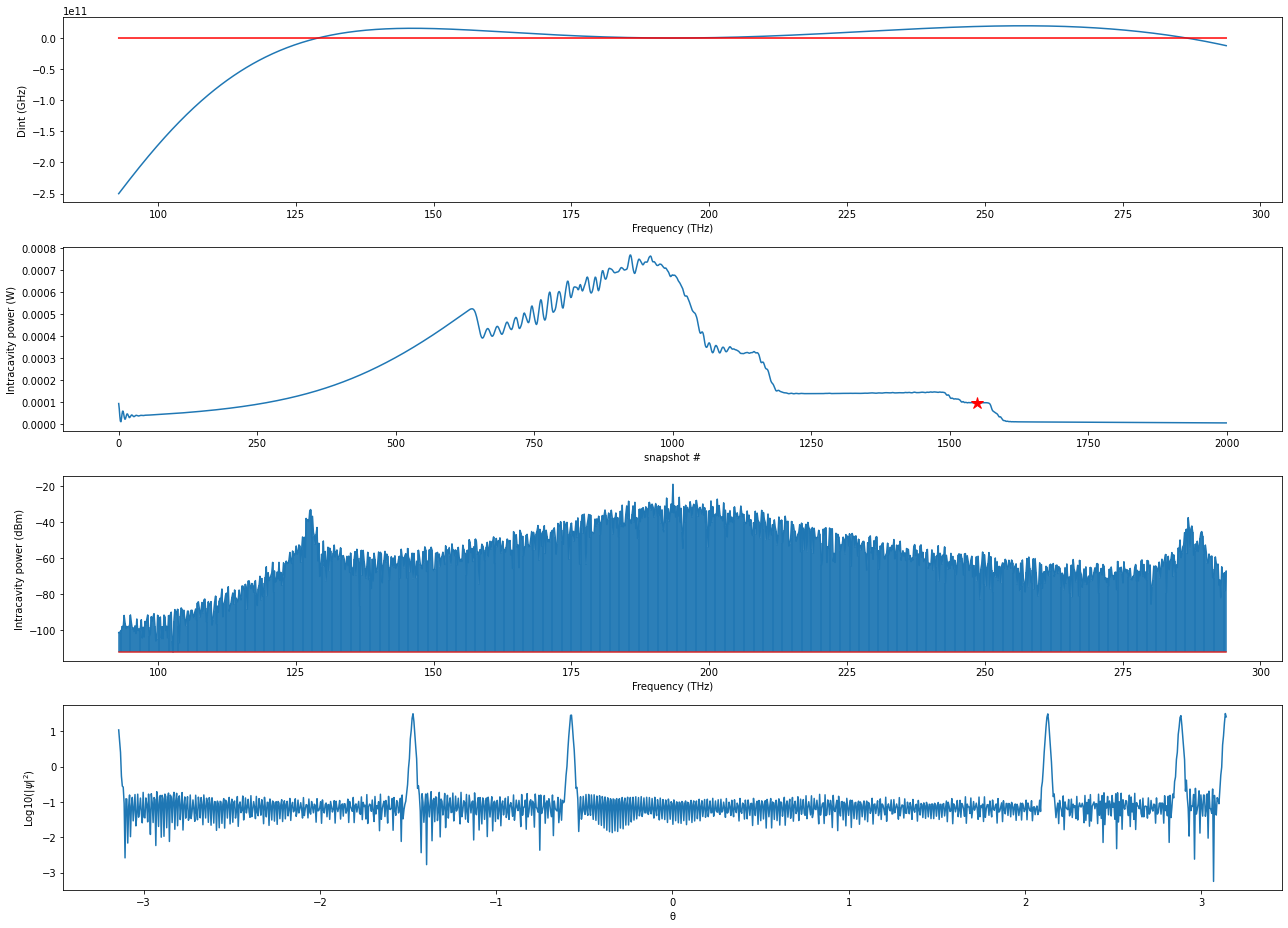

In [146]:
ninth.plot_all(1550)

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 9670724.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 6.043759884504241


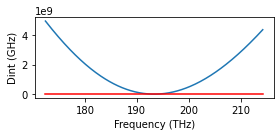

In [128]:
# use pyfftw

eighth = microring(Nmodes=2**8,total_time=1e-6,δnorm_range=[-8,20],pump=150e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9,snapshots=1000)
eighth.plot_Dint()

In [129]:
eighth.split_step(plan_fft=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

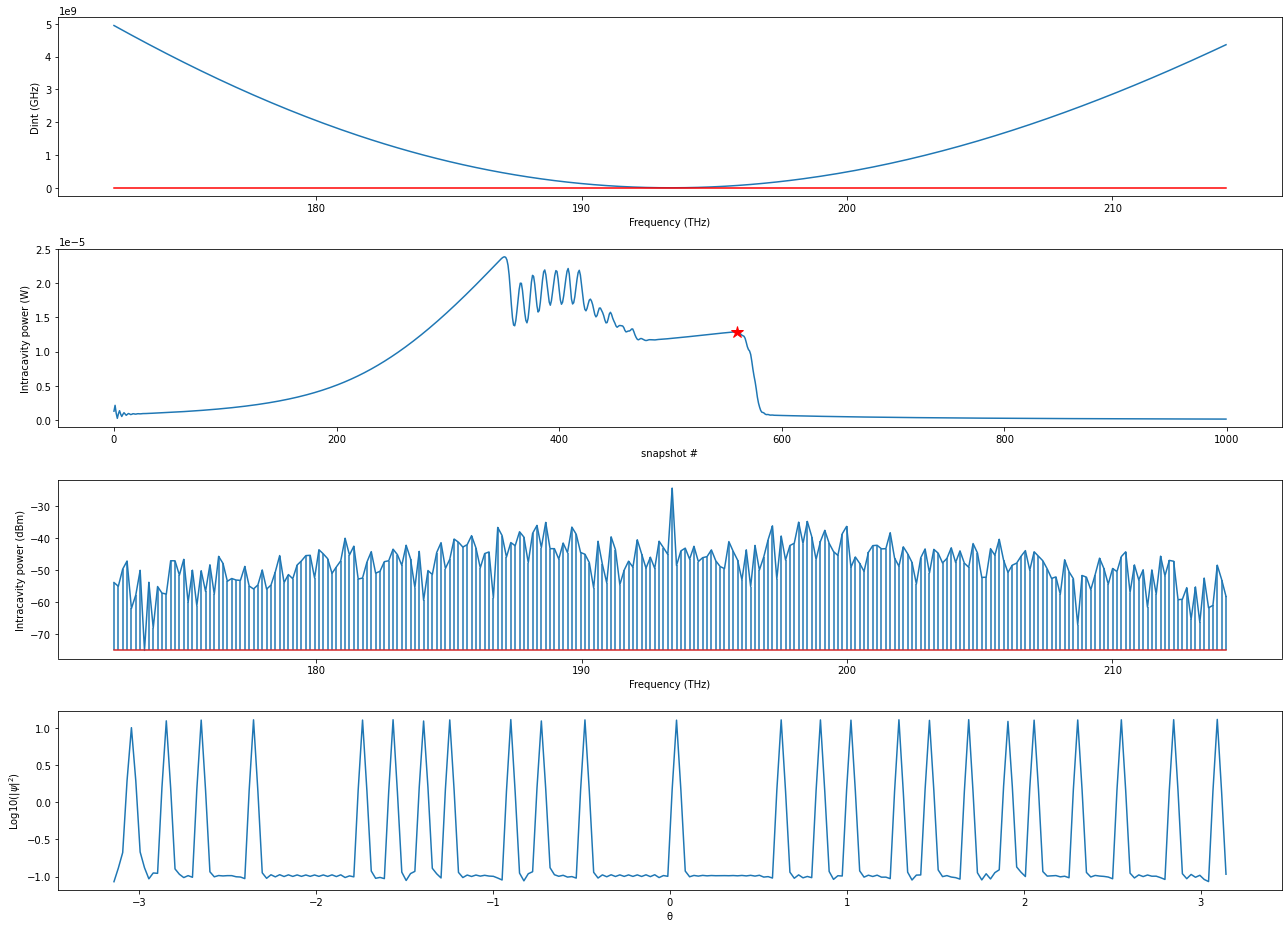

In [137]:
eighth.plot_all(560)

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 6447149.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 4.02917325633616


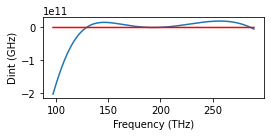

In [97]:
# use pyfftw

seventh = microring(Nmodes=2**10+150,total_time=1e-6,δnorm_range=[-8,20],pump=100e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv',Dint_degrees=9)
seventh.plot_Dint()

In [98]:
seventh.split_step(plan_fft=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

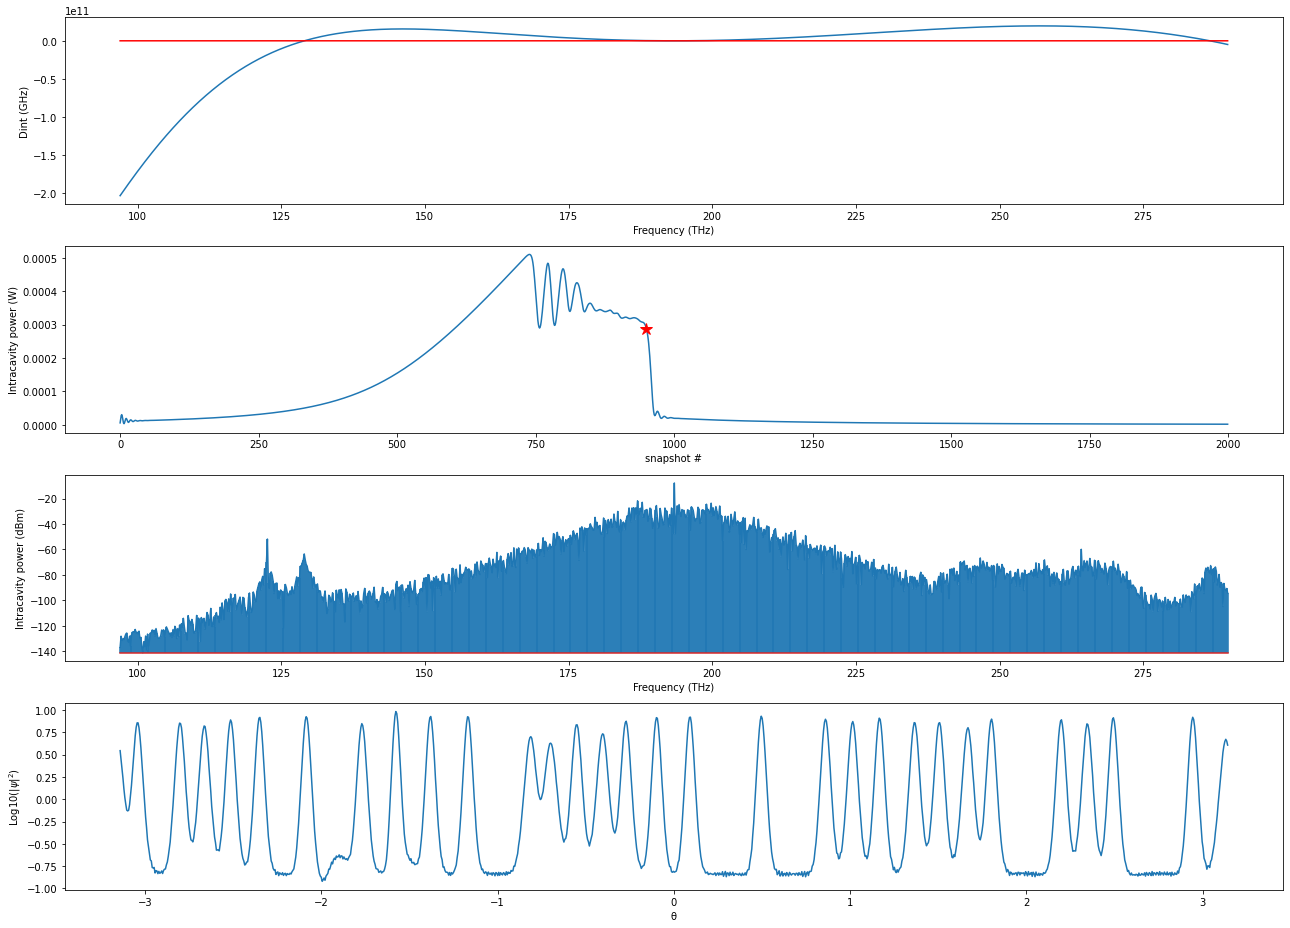

In [99]:
seventh.plot_all(950)

In [27]:
# use pyfftw

sixth = microring(Nmodes=2**8,total_time=1e-6,δnorm_range=[-8,20],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv')

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


In [28]:
sixth.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

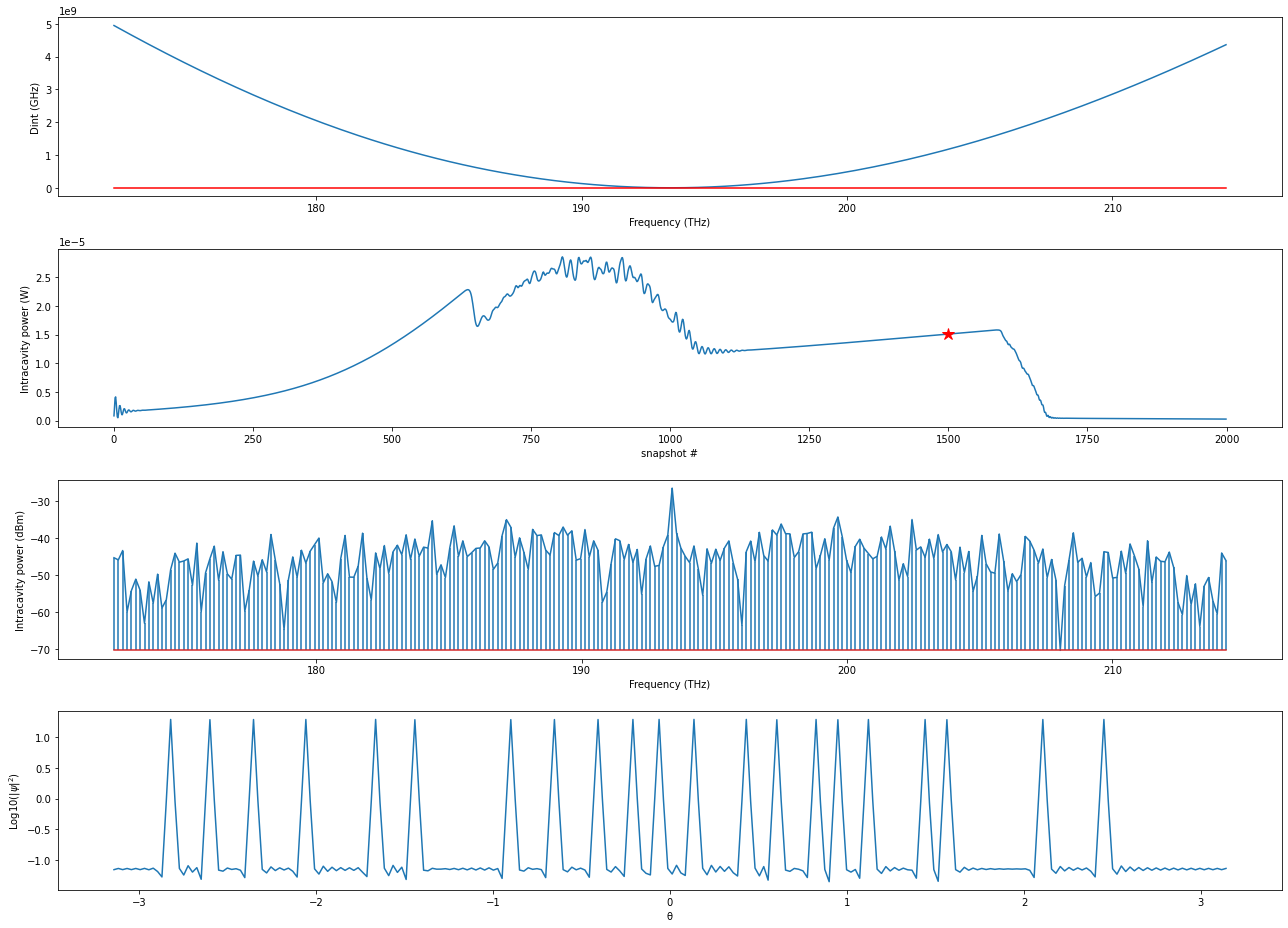

In [29]:
sixth.plot_all(1500)

In [20]:

Num_of_modes = 2**7

D2 = 15e6 # Hz


mu = np.arange(-Num_of_modes/2,Num_of_modes/2)
Dint = (mu**2*D2/2)
# second = microring(Nmodes=Num_of_modes,total_time=1e-6,δnorm_range=[-8,40],pump=1000e-3,dt=1e-3)

# second.Δωext = 0.998**mu*25e6
fifth = microring(Nmodes=2**8,total_time=1e-6,δnorm_range=[-8,20],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv')


ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


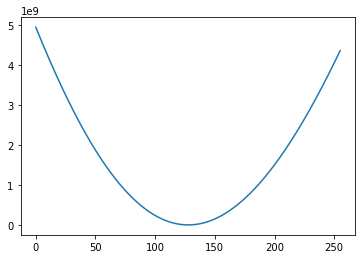

In [21]:
plt.plot(np.fft.fftshift(fifth.Dint_arr))

In [22]:
fifth.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

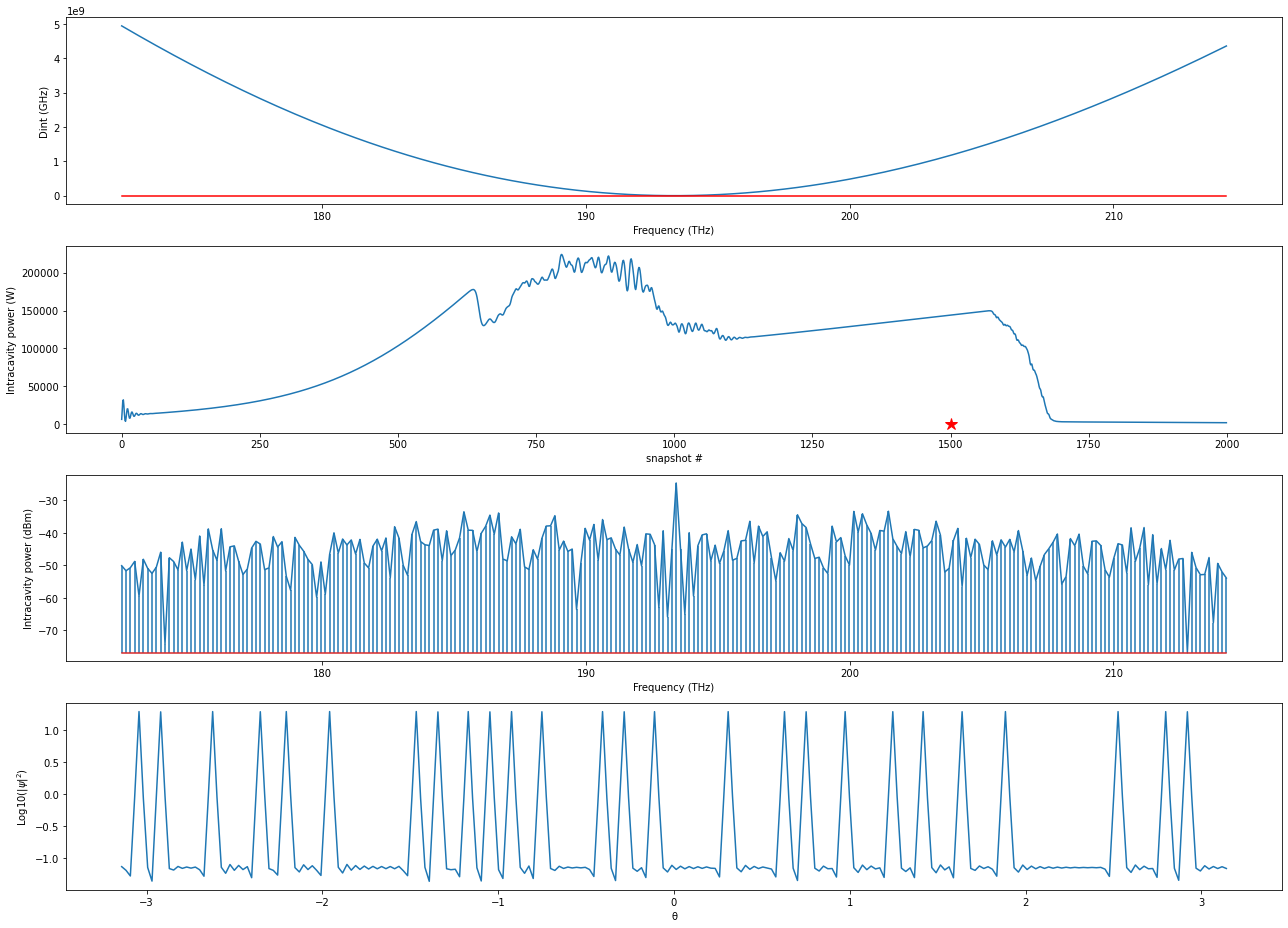

In [24]:
fifth.plot_all(1500)

In [1055]:
np.sum(np.abs(fourth.sol[:])**2,axis=1)/fourth.normalization**2*fourth.h*fourth.ω0

array([1.72891740e-05, 5.37180379e-05, 8.29655843e-05, ...,
       2.38140091e-06, 2.37838262e-06, 2.37537007e-06])

In [1088]:
differences = (np.diff(np.sum(np.abs(fourth.sol[:])**2,axis=1)))
idx = np.where(differences>0)[0][np.argmin(differences[np.where(differences>0)])]-100

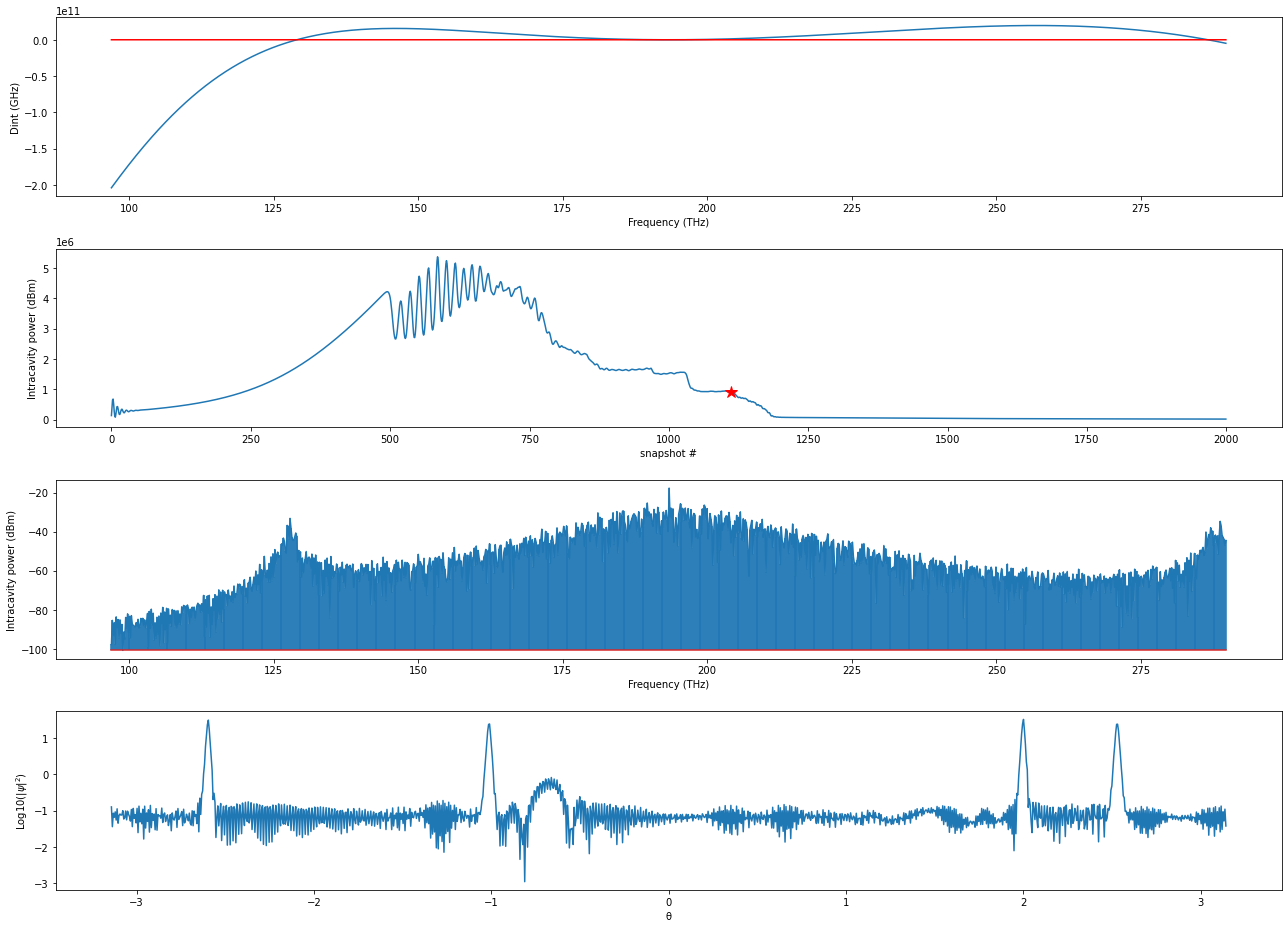

In [1107]:
fig, axs = plt.subplots(4,1,figsize=(18,13))
zeros_arr = np.linspace(0,0,fourth.Nmodes)
axs[0].plot(fourth.ωarr/1e12,np.fft.fftshift(fourth.Dint_arr))
axs[0].plot(fourth.ωarr/1e12,zeros_arr,'r-')
axs[0].set_xlabel('Frequency (THz)')
axs[0].set_ylabel('Dint (GHz)')

axs[1].plot(np.sum(np.abs(fourth.sol[:])**2,axis=1))
axs[1].plot(idx,np.sum(np.abs(fourth.sol[idx])**2),'r*',markersize=12)
axs[1].set_xlabel('snapshot #')
axs[1].set_ylabel('Intracavity power (dBm)')

axs[2].stem(fourth.ωarr/1e12,10*np.log10(np.abs(np.fft.fftshift(fourth.sol[idx]))**2*1e3/fourth.normalization**2*fourth.h*fourth.ω0),
         bottom=np.min(10*np.log10(np.abs(np.fft.fftshift(fourth.sol[idx]))**2*1e3/fourth.normalization**2*fourth.h*fourth.ω0)),markerfmt='')
axs[2].set_xlabel('Frequency (THz)')
axs[2].set_ylabel('Intracavity power (dBm)')
axs[3].plot(np.linspace(-np.pi,np.pi,fourth.Nmodes),np.log10(np.abs(np.fft.ifft(fourth.sol[1150]))**2))
axs[3].set_xlabel('θ')
axs[3].set_ylabel('Log10($|\psi|^2$)')
fig.tight_layout()
plt.show()

In [986]:
fourth = microring(Nmodes=2**10+150,total_time=1e-6,δnorm_range=[-8,30],pump=300e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv')

ω_start = 193.4160363481703 THz, ω_end = 193.4086865975871 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.046501395042 nm
normalized detunings = [ -8 , 30 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 7349750.58321875 GHz/s 
sweep speed (λ space) = 58901.29584266704 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 5.80243467096875 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


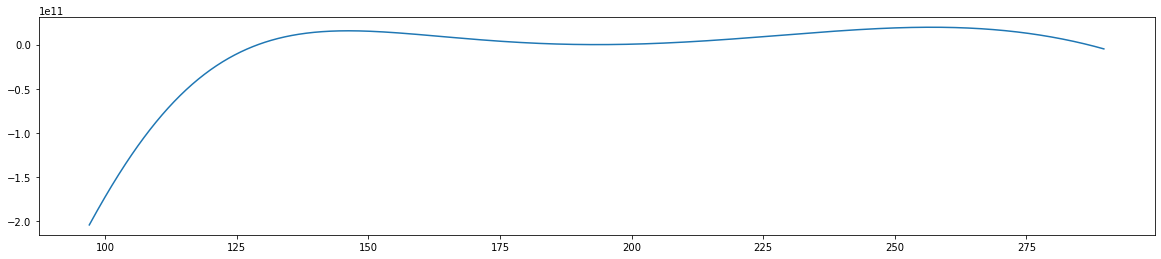

In [987]:
plt.plot(fourth.ωarr/1e12,np.fft.fftshift(fourth.Dint_arr))

In [988]:
fourth.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

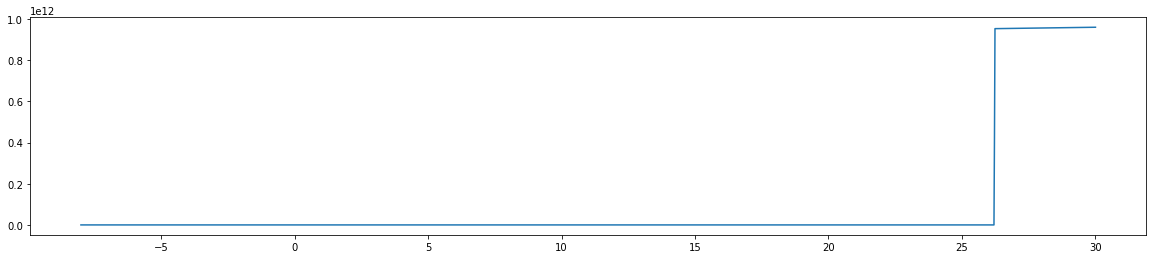

In [1144]:
plt.plot(fourth.δ_snapshots,np.sum(np.abs(fourth.sol[:])**2,axis=1)/fourth.normalization**2*fourth.h*(fourth.ω0))

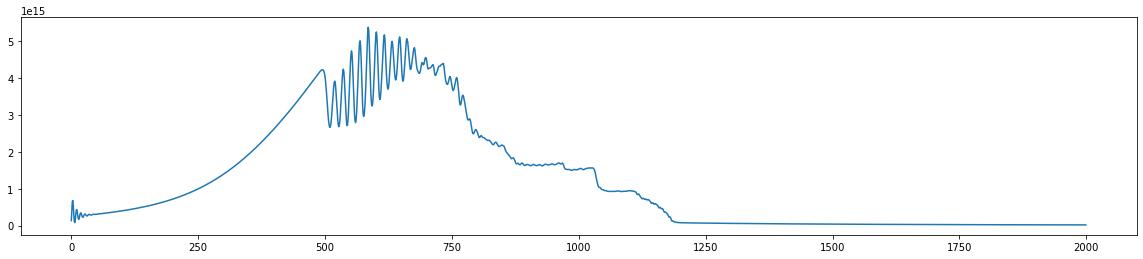

In [990]:
plt.plot(np.sum(np.abs(fourth.sol[:])**2/fourth.normalization**2,axis=1))

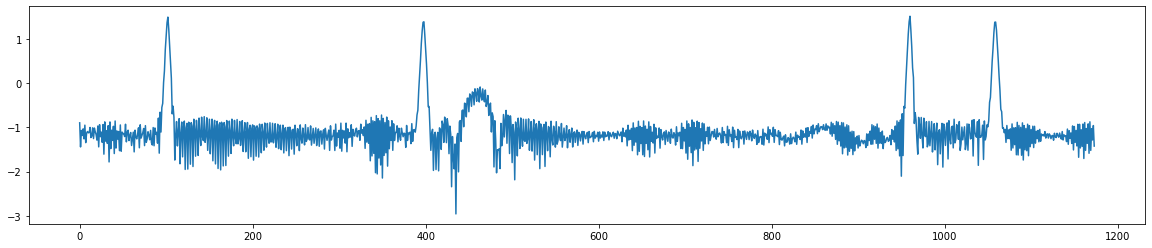

In [1007]:
plt.plot(np.log10(np.abs(np.fft.ifft(fourth.sol[1150]))**2))

(-80.0, 0.0)

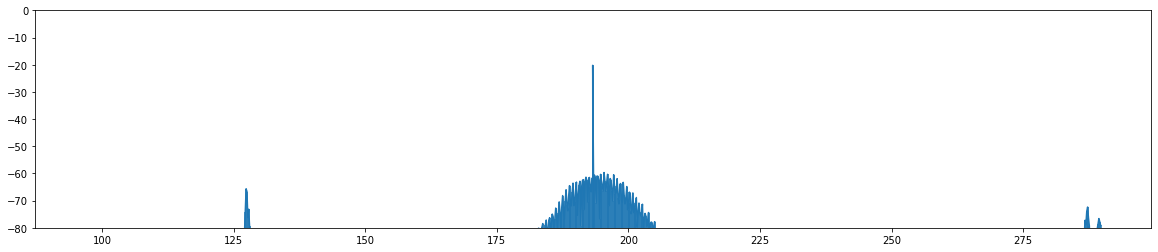

In [1087]:
plt.stem(fourth.ωarr_adjusted/1e12,10*np.log10(np.abs(np.fft.fftshift(fourth.sol[1170]))**2*1e3/fourth.normalization**2*fourth.h*fourth.ω0),
         bottom=np.min(10*np.log10(np.abs(np.fft.fftshift(fourth.sol[1170]))**2*1e3/fourth.normalization**2*fourth.h*fourth.ω0)),markerfmt='')
plt.ylim([-80,0])

In [944]:
third = microring(Nmodes=2**9,total_time=1e-6,δnorm_range=[-8,40],pump=1000e-3,dt=1e-3,Dint_file='2.300w_58.5r_0.945h.csv')

ω_start = 193.4160363481703 THz, ω_end = 193.4067524526968 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0620024800992 nm
normalized detunings = [ -8 , 40 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 9283895.47353125 GHz/s 
sweep speed (λ space) = 74402.38089981774 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 19341448.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 7.73657956128125 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 12.087519769008482


In [945]:
third.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

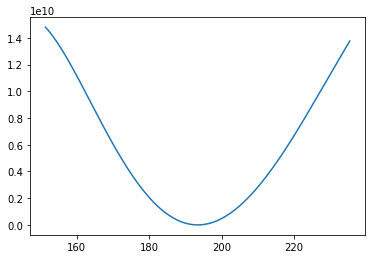

In [943]:
plt.plot(third.ωarr/1e12,np.fft.fftshift(third.Dint_arr))

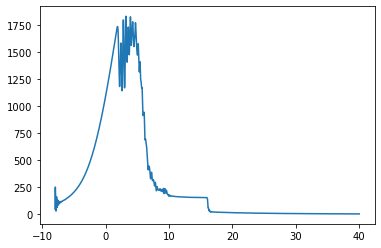

In [950]:
third.plot_intracavity_power()

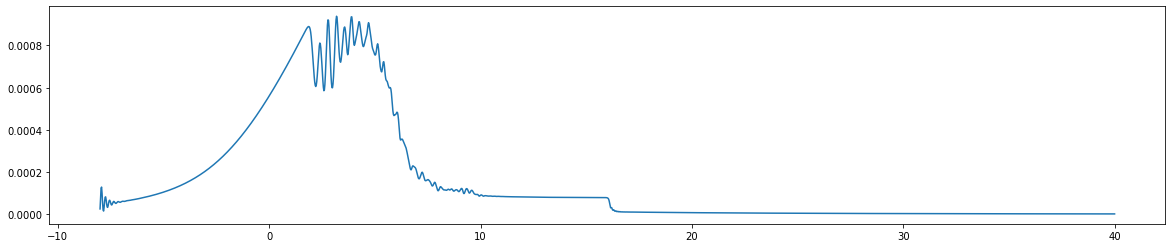

In [959]:
plt.plot(third.δ_snapshots,np.sum(np.abs(third.sol[:])**2/third.normalization**2,axis=1))

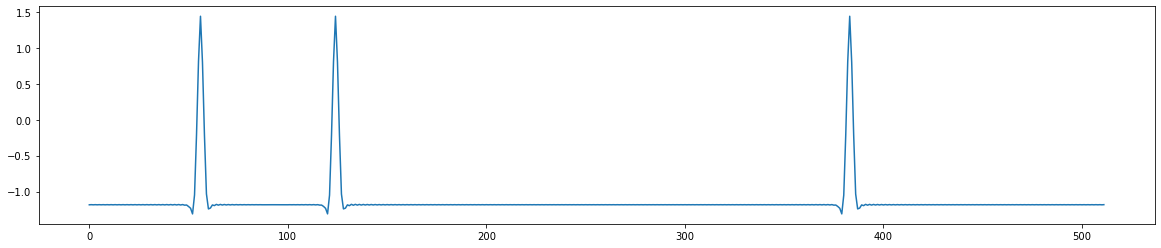

In [957]:
plt.plot(np.log10(np.abs(np.fft.ifft(third.sol[900]))**2))

<StemContainer object of 3 artists>

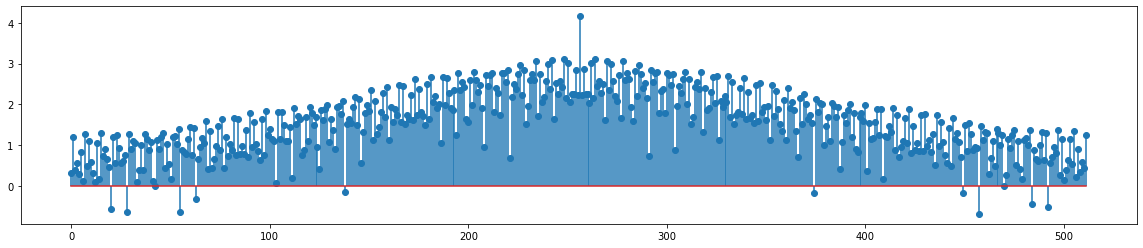

In [958]:
plt.rcParams["figure.figsize"] = (20,4)
plt.stem(np.log10(np.abs(np.fft.fftshift(third.sol[990]))**2))

In [922]:

Num_of_modes = 2**9

D2 = 15e6 # Hz


mu = np.arange(-Num_of_modes/2,Num_of_modes/2)
Dint = (mu**2*D2/2)
second = microring(Nmodes=Num_of_modes,total_time=1e-6,δnorm_range=[-8,40],pump=1000e-3,dt=1e-3)
# second.Dint_arr = np.fft.ifftshift(Dint)
# second.Δωext = 0.998**mu*25e6

ω_start = 193.4160363481703 THz, ω_end = 193.4067524526968 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0620024800992 nm
normalized detunings = [ -8 , 40 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 9283895.47353125 GHz/s 
sweep speed (λ space) = 74402.38089981774 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 64471496.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 7.73657956128125 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 8.
g0 = 0.1931696915601886, Veff = 1.9075750592597225e-15, F^2 = 40.29173256336161


In [928]:
second.Δωtot

386828978.0645161

In [923]:
second.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

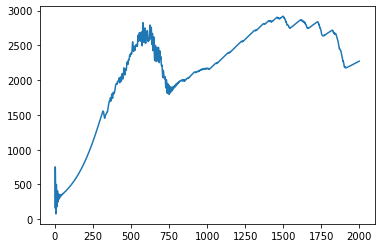

In [924]:
plt.plot(np.mean(np.abs(second.sol[:])**2,axis=1))

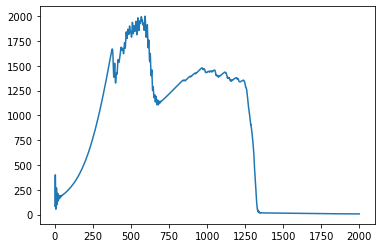

In [910]:
plt.plot(np.mean(np.abs(second.sol[:])**2,axis=1))

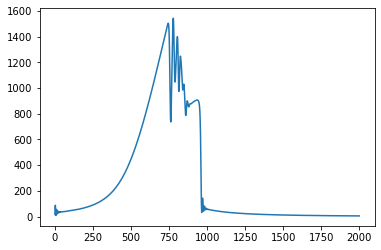

In [896]:
plt.plot(np.mean(np.abs(second.sol[:])**2,axis=1)) # 100e-3 pump, 30 detune

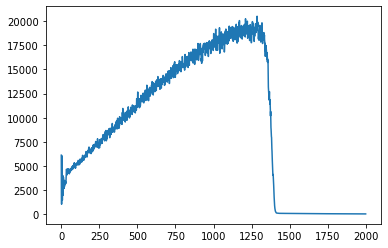

In [878]:
plt.plot(np.mean(np.abs(second.sol[:])**2,axis=1))

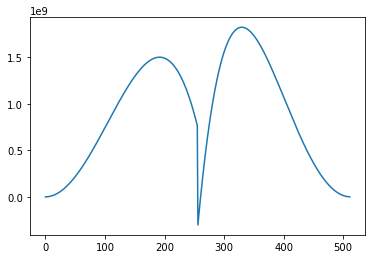

In [902]:
plt.plot((second.Dint_arr))

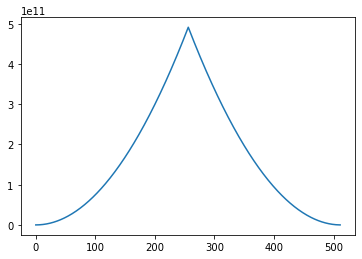

In [899]:
plt.plot((second.Dint_arr))

In [814]:
second.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

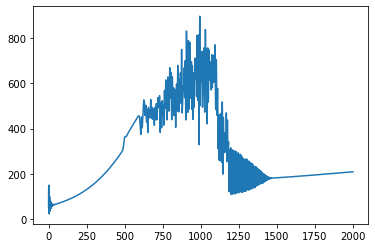

In [815]:
plt.plot(np.mean(np.abs(second.sol[:])**2,axis=1))

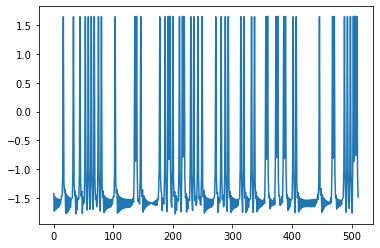

In [925]:
plt.plot(np.log10(np.abs(np.fft.ifft(second.sol[1990]))**2))

In [234]:
first.split_step()

  0%|          | 0/2000 [00:00<?, ?it/s]

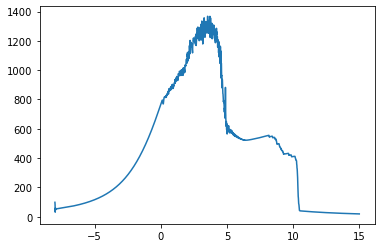

In [235]:
first.plot_intracavity_power() # add noise every dt

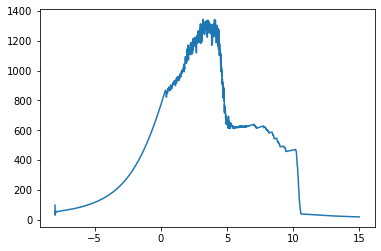

In [218]:
first.plot_intracavity_power() # add noise every Nsim/2000 dt's

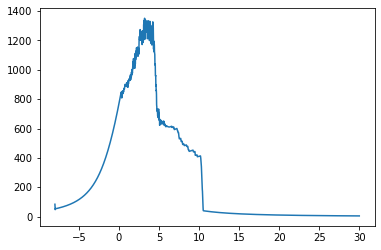

In [176]:
first.plot_intracavity_power()

In [174]:
first.δarr

array([-1.54731591e+09, -1.54731401e+09, -1.54731211e+09, ...,
        5.80243087e+09,  5.80243277e+09,  5.80243467e+09])

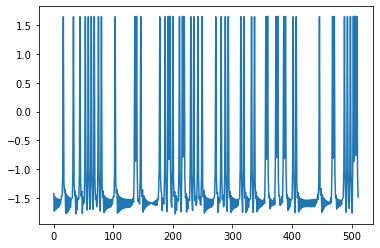

In [926]:
plt.plot(np.log10(np.abs(np.fft.ifft(second.sol[1990]))**2))

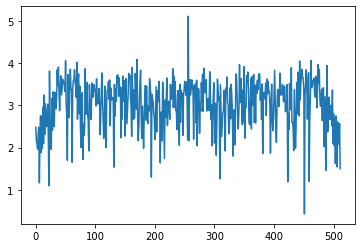

In [927]:
plt.plot(np.log10(np.abs(np.fft.fftshift(second.sol[1990]))**2))

In [656]:
divby2000 = first.Nsim//first.Nsnapshots

In [75]:
(first.Nsim-(first.Nsim%divby2000+divby2000))/divby2000#/((first.Nsim+(2000-first.Nsim%first.Nsnapshots))//first.Nsnapshots)

2000.0

In [30]:
(2000-first.Nsim%first.Nsnapshots)

1421.0

In [400]:
second.seed

array([0.07701807, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

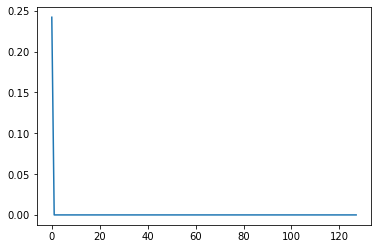

In [414]:
plt.plot(second.seed)

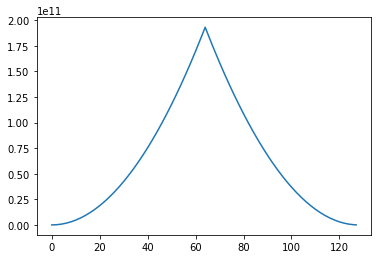

In [426]:
plt.plot(np.fft.fftshift(second.Dint_arr)*2*np.pi)

In [434]:
second.δarr

array([-1.54731591e+09, -1.54731016e+09, -1.54730441e+09, ...,
        2.90120584e+09,  2.90121159e+09,  2.90121734e+09])

In [341]:
first.Δωtot

38682.89780645161

In [343]:
299792458/1550e-6*2*np.pi/κ

3868.2897806451615

In [ ]:
# Waste


c = 299792458
ħ = 1.0545718e-34
Qi = 500000
Qc = 500000
Qtot = ( 1/Qi + 1/Qc )**-1
ω0 = c/1550e-9
λp = 1550e-9
ωp = c/λp
λp_start = 1549.99e-9# np.linspace(1548e-9,1551e-9,10000)
λp_end = 1550.03e-9
ωp_start = c/λp_start
ωp_end = c/λp_end
R = 60e-6 # radius
ng = 2.2
τ_tot = Qtot/ω0
FSR = c/(ng * 2*np.pi*R)
t = 1e-3 # seconds
t_roundtrip = 2*np.pi*ng*R/c
# we can normalize time to number of roundtrips
t_normal = t/t_roundtrip
# t_normal = t/(2*τ_tot)

β = -0.004 # Taylor expansion second order coefficient normalized by ω0/2 (half linewidth of the mode)
α = 1/τ_tot/2
γ = 1.4
F = 10 # pump normalized to threshold of parametric oscillation F^2 = pump/pump_threshold
# initialize ψ with noise
pump = 2 # watts
κext = ω0/Qc
F = np.sqrt(2*pump*κext)

Nmodes = 301
ωstart = ωp - (Nmodes//2) * FSR
ωend = ωp + (Nmodes//2) * FSR
# should i use cold cavity resonances or dispersion adjusted resonances?
ωarr = np.linspace(ωstart,ωend,Nmodes)
Dint_coeffs = np.array([ 7.38392840e-07, -1.08366836e-03,  6.20323154e-01, -1.52824970e+02,
                        2.00631574e+01,  9.25526200e+06, -2.25798494e+09,  2.33413386e+11,
                        -9.25346061e+12])
Dint_arr = PolyCoefficients(ωarr/1e12,Dint_coeffs)
# adjust mode wavelengths from calculated Dint
ωarr_adjusted = ωarr + Dint_arr

ψ = np.random.rand(Nmodes)/1#/np.sqrt(1e1) # starts off in the time domain
ψ = np.fft.ifft(ψ)

# simulation environment
Nsim = 300000
ωp_arr = np.linspace(ωp_start,ωp_end,Nsim)
tstep = t/Nsim